In [1]:
!pip install tensorflow-recommenders
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 3.5 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 47.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 20.7 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [83]:
# import required packages
# utility
import re
import sys
import html
import pprint
import numpy as np
import pandas as pd
from typing import Dict, Text

# plots
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow_recommenders as tfrs

In [3]:
# # configure gpu
# gpus = tf.config.list_physical_devices("GPU")

# print("Num GPUs Available: ", len(gpus))

# # if gpus:
# #     # Create 2 virtual GPUs with 4GB memory each
# #     try:
# #         tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=4096), tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
# #         logical_gpus = tf.config.list_logical_devices("GPU")
# #         print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
# #     except RuntimeError as e:
# #         # Virtual devices must be set before GPUs have been initialized
# #         print(e)

# strategy = tf.distribute.MirroredStrategy()

In [4]:
# # configure tpu
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(resolver)

# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

# strategy = tf.distribute.TPUStrategy(resolver)

## EDA and Preprocessing: Anime Recommendations Dataset
- Ratings data
- Metadata

### Ratings data

In [5]:
# load ratings dataset
# kaggle path
# rating_df = pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')

# local path
rating_df = pd.read_csv('../data/rating.csv')

rating_df.shape

(7813737, 3)

In [6]:
# first 5 data points
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
# info
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [8]:
# convert id columns to string
rating_df['user_id'] = rating_df['user_id'].map(lambda x: str(x))
rating_df['anime_id'] = rating_df['anime_id'].map(lambda x: str(x))

In [9]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Metadata

In [10]:
# load anime metadata
# kaggle path
# anime_df = pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv')

# local path
rating_df = pd.read_csv('../data/anime.csv')

anime_df.shape

(12294, 7)

In [11]:
# first 5 data points
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [12]:
# drop useless columns
# members
anime_df = anime_df.drop(['members'], axis=1)

In [13]:
# check null values
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
dtype: int64

In [14]:
# replace null values for genre with mode
anime_df['genre'] = anime_df['genre'].fillna(anime_df['genre'].mode()[0])

# replace null values for type with mode
anime_df['type'] = anime_df['type'].fillna(anime_df['type'].mode()[0])

# replace null value for rating with mean
anime_df['rating'] = anime_df['rating'].fillna(anime_df['rating'].mean())

In [15]:
# verify null values handling
anime_df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
dtype: int64

In [16]:
# info
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12294 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 576.4+ KB


In [17]:
# convert anime_id column to string
anime_df['anime_id'] = anime_df['anime_id'].apply(lambda x: str(x))

In [18]:
# sample anime name with invalid characters
anime_df['name'].loc[8441]

'Dennou Sentai Voogie&#039;s★Angel: Forever and Ever'

In [19]:
# clean anime name column
# remove html encodings
# convert to regular characters
anime_df['name'] = anime_df['name'].apply(html.unescape)

# remove emojis and other miscellaneous unicode characters
# encode as ascii to remove miscellaneous unicode characters
# replaces the characters with '?'
# converts str to array of bytes
anime_df['name'] = anime_df['name'].map(lambda x: x.encode('ascii', 'replace'))

# decode to convert to str
anime_df['name'] = anime_df['name'].map(lambda x: x.decode())

# replace '?' with a space
anime_df['name'] = anime_df['name'].map(lambda x: x.replace('?', ' '))

# convert to lower case
anime_df['name'] = anime_df['name'].map(lambda x: x.lower())

# remove punctuations
anime_df['name'] = anime_df['name'].map(lambda x: re.sub(r'[^\w\s]', ' ', x))

# remove single length words
anime_df['name'] = anime_df['name'].map(lambda x: re.sub(r'\b\w{1}\b', '', x))

# remove extra spaces
anime_df['name'] = anime_df['name'].map(lambda x: re.sub(r' +', ' ', x))

In [20]:
# verify cleaning of anime name column
anime_df['name'].loc[8441]

'dennou sentai voogie angel forever and ever'

In [21]:
# clean and normalize genre column
# convert to lower case
anime_df['genre'] = anime_df['genre'].map(lambda x: x.lower())

# remove punctuations
# keep hyphen(-) for sci-fi
anime_df['genre'] = anime_df['genre'].map(lambda x: re.sub(r'[^\w\s-]', ' ', x))

# remove single length characters
anime_df['genre'] = anime_df['genre'].map(lambda x: re.sub(r'\b\w{1}\b', '', x))

# remove extra spaces
anime_df['genre'] = anime_df['genre'].map(lambda x: re.sub(r' +', ' ', x))

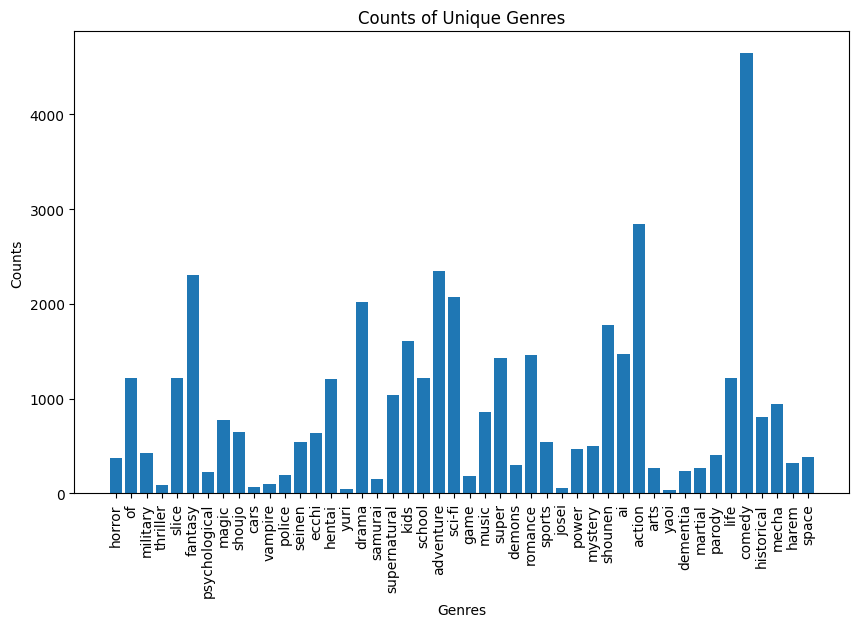

In [22]:
# plot the count of each genre

# extract unique genres
unique_genres = set()
for genres in anime_df['genre']:
    unique_genres.update(genres.split())

# count the number of anime for each genre
genre_counts = {}
for genre in unique_genres:
    genre_counts[genre] = sum(anime_df['genre'].str.contains(genre))

# plot the genre counts
plt.figure(figsize=(10,6))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Counts of Unique Genres');

del unique_genres
del genre_counts

In [23]:
# normalize type column
# convert to lower case
anime_df['type'] = anime_df['type'].map(lambda x: x.lower())

# no further cleaning required for type column

In [24]:
# anime_df['episodes'] = anime_df['episodes'].apply(lambda x: float(x))
# errorneous value for episodes column
anime_df[anime_df['episodes'] == 'Unknown']

,anime_id,name,genre,type,episodes,rating
74,21,one piece,action adventure comedy drama fantasy shounen ...,tv,Unknown,8.580000
252,235,detective conan,adventure comedy mystery police shounen,tv,Unknown,8.250000
615,1735,naruto shippuuden,action comedy martial arts shounen super power,tv,Unknown,7.940000
991,966,crayon shin chan,comedy ecchi kids school shounen slice of life,tv,Unknown,7.730000
1021,33157,tanaka kun wa itsumo kedaruge specials,comedy school slice of life,special,Unknown,7.720000
...,...,...,...,...,...,...
12265,34361,kyonyuu reijou mc gakuen,hentai,ova,Unknown,6.473902
12274,34492,nuki doki tenshi to akuma no sakusei battle re...,hentai,ova,Unknown,6.473902
12280,34312,saimin class,hentai,ova,Unknown,6.473902
12282,34388,shikkoku no shaga the animation,hentai,ova,Unknown,6.473902


In [25]:
# handle errorneous value for episodes column
anime_df['episodes'] = anime_df['episodes'].replace('Unknown', str(sys.maxsize))

# convert episodes column from string to float
anime_df['episodes'] = anime_df['episodes'].apply(lambda x: float(x))

In [26]:
# rename rating column to avoid confusion with user rating column
anime_df = anime_df.rename({'rating': 'score'}, axis=1)

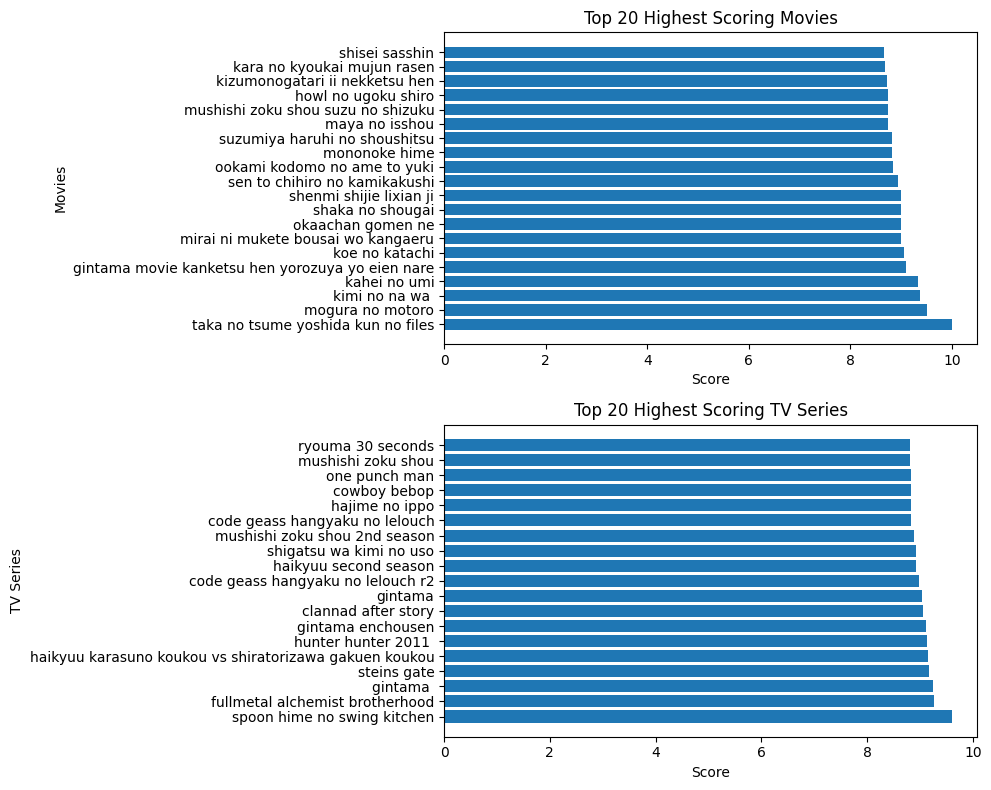

In [27]:
# filter for movies and sort by score
movies_df = anime_df[anime_df["type"] == "movie"].sort_values(by="score", ascending=False).head(20)

# Filter for TV series and sort by score
tv_df = anime_df[anime_df["type"] == "tv"].sort_values(by="score", ascending=False).head(20)

# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].barh(movies_df["name"], movies_df["score"])
ax[0].set_title("Top 20 Highest Scoring Movies")
ax[0].set_xlabel("Score")
ax[0].set_ylabel("Movies")

ax[1].barh(tv_df["name"], tv_df["score"])
ax[1].set_title("Top 20 Highest Scoring TV Series")
ax[1].set_xlabel("Score")
ax[1].set_ylabel("TV Series")

plt.tight_layout();

del movies_df
del tv_df

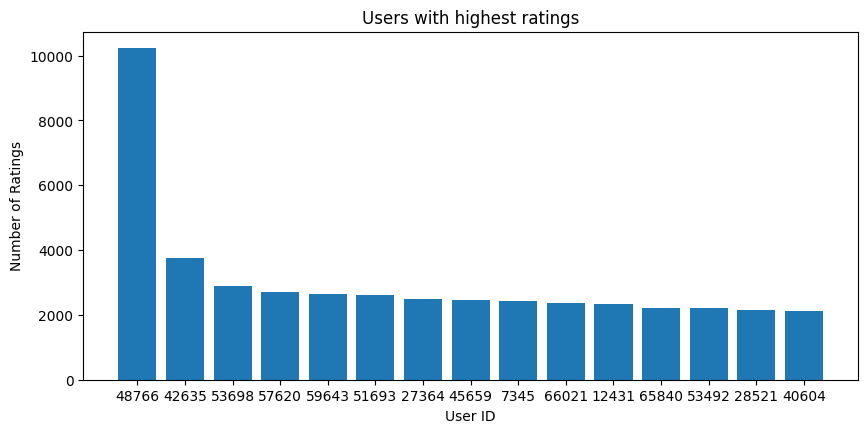

In [28]:
num_ratings = rating_df.groupby("user_id").size().reset_index(name="num_ratings")
num_ratings = num_ratings.sort_values(by="num_ratings", ascending=False)[:15]

plt.figure(figsize=(10,6))
plt.bar(num_ratings["user_id"], num_ratings["num_ratings"])
plt.xlabel("User ID")
plt.ylabel("Number of Ratings")
plt.title('Users with highest ratings')
plt.subplots_adjust(bottom=0.3);

del num_ratings

In [29]:
# add columns from metadata to ratings dataframe
rating_df = pd.merge(rating_df, anime_df, on='anime_id')

rating_df.shape

(7813727, 8)

In [30]:
# first 5 data points
rating_df.head()

,user_id,anime_id,rating,name,genre,type,episodes,score
0,1,20,-1,naruto,action comedy martial arts shounen super power,tv,220.0,7.81
1,3,20,8,naruto,action comedy martial arts shounen super power,tv,220.0,7.81
2,5,20,6,naruto,action comedy martial arts shounen super power,tv,220.0,7.81
3,6,20,-1,naruto,action comedy martial arts shounen super power,tv,220.0,7.81
4,10,20,-1,naruto,action comedy martial arts shounen super power,tv,220.0,7.81


In [31]:
# create vocabulary of all features
# vocabulary of user ids
vocab_user_ids = rating_df['user_id'].unique().astype(str)

# vocabulary of anime titles
vocab_anime_titles = rating_df['name'].unique().astype(str)

# vocabulary of genres
vocab_genres = rating_df['genre'].unique().astype(str)

# vocabulary of type
vocab_types = rating_df['type'].unique().astype(str)

# vocabulary of episodes
vocab_episodes = rating_df['episodes'].unique().astype(float)

# vocabulary of score
vocab_scores = rating_df['score'].unique().astype(float)

In [32]:
# create vocabulary of animes
# convert anime metadata from dataframe to tensorflow Dataset
animes = tf.data.Dataset.from_tensor_slices(dict(anime_df[['name', 'genre', 'type', 'episodes', 'score']].rename({'name': 'anime_title'}, axis=1)))

# keep only anime title column
animes = animes.map(lambda x: x['anime_title'])

for x in animes.take(1).as_numpy_iterator():
    pprint.pprint(x)

b'kimi no na wa '


## Retrieval Model

### Prepare Data


In [33]:
# convert rating data from dataframe to tensorflow Dataset
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_df))

# keep only user_id and anime_name column
ratings = ratings.map(lambda x: {
    'user_id': x['user_id'],
    'anime_title': x['name'],
})

for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'anime_title': b'naruto', 'user_id': b'1'}


In [34]:
# shuffle and split data: train, valid, test
# set seed
tf.random.set_seed(42)

# total data points
N = rating_df.shape[0]

# total train data points
N_train = int(0.6 * N)

# total valid data points
N_valid = int(0.2 * N)

# total test data points
N_test = N - (N_train + N_valid)

# shuffle data
shuffled = ratings.shuffle(N, seed=42, reshuffle_each_iteration=False)

# split data
train = shuffled.take(N_train)
valid = shuffled.skip(N_train).take(N_valid)
test = shuffled.skip((N_train + N_valid)).take(N_test)

### Model Architecture

In [35]:
class AnimeRetrievalModel(tfrs.Model):
    
    def __init__(self):
        super().__init__()
        
        # dimension of all the embeddings
        embedding_dimension = 32
        
        # user embedding model
        # computes user embeddings
        self.user_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_user_ids) + 1, embedding_dimension)
        ])
        
        # anime embedding model
        # computes anime embeddings
        self.anime_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_anime_titles, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_anime_titles) + 1, embedding_dimension)
        ])
        
        # retrieval task
        self.task = tfrs.tasks.Retrieval(
            metrics = tfrs.metrics.FactorizedTopK(
                candidates=animes.batch(1024).map(self.anime_embedding_model)
            )
        )
        
    def compute_loss(self, features, training=False):
        # compute user embeddings
        user_embeddings = self.user_embedding_model(features['user_id'])
        
        # compute anime embeddings
        anime_embeddings = self.anime_embedding_model(features['anime_title'])
        
        # computes the loss and the metrics
        # compute_metrics=not training:
        # - turns metric calculation off while training
        # - speeds up training
        return self.task(user_embeddings, anime_embeddings, compute_metrics=not training)

In [36]:
# initialize model
model = AnimeRetrievalModel()

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [37]:
# cache data for training
cached_train = train.shuffle(N_train).batch(8192).cache()
cached_valid = valid.batch(4096).cache()

### Train & Evaluate Model

In [38]:
# train model
history = model.fit(cached_train, epochs=1)

573/573 [==============================] - 213s 188ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 74701.4941 - regularization_loss: 0.0000e+00 - total_loss: 74701.4941


In [39]:
# evaluate model
model.evaluate(cached_valid, return_dict=True)

382/382 [==============================] - 244s 369ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.5358e-05 - factorized_top_k/top_10_categorical_accuracy: 2.7644e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0190 - factorized_top_k/top_100_categorical_accuracy: 0.0550 - loss: 34509.3952 - regularization_loss: 0.0000e+00 - total_loss: 34509.3952


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 1.53575911099324e-05,
 'factorized_top_k/top_10_categorical_accuracy': 0.0002764366508927196,
 'factorized_top_k/top_50_categorical_accuracy': 0.01896662637591362,
 'factorized_top_k/top_100_categorical_accuracy': 0.05496034398674965,
 'loss': 16727.46484375,
 'regularization_loss': 0,
 'total_loss': 16727.46484375}

### Making Predictions

In [40]:
# use fatorized_top_k.BruteForce layer to make predictions
# facilitates input raw query features,
# embedding it and recommending movies out of the entire dataset

# create the single layer model
index = tfrs.layers.factorized_top_k.BruteForce(model.user_embedding_model)

# generate recommendations
index.index_from_dataset(
  tf.data.Dataset.zip((animes.batch(100), animes.batch(100).map(model.anime_embedding_model)))
)

# get recommendation for specific user
# user_id: 42
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'hungry to win' b'nulu chan to boku' b'fruity samurai']


## Ranking Model

### Prepare Data

In [41]:
# convert rating data from dataframe to tensorflow Dataset
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_df))

# keep only user_id, anime_name and rating columns
ratings = ratings.map(lambda x: {
    'anime_title': x['name'],
    'user_id': x['user_id'],
    'user_rating': x['rating']
})

for x in ratings.take(5).as_numpy_iterator():
    pprint.pprint(x)

{'anime_title': b'naruto', 'user_id': b'1', 'user_rating': -1}
{'anime_title': b'naruto', 'user_id': b'3', 'user_rating': 8}
{'anime_title': b'naruto', 'user_id': b'5', 'user_rating': 6}
{'anime_title': b'naruto', 'user_id': b'6', 'user_rating': -1}
{'anime_title': b'naruto', 'user_id': b'10', 'user_rating': -1}


In [42]:
# shuffle and split data: train, valid, test
# total data points
N = rating_df.shape[0]

# total train data points
N_train = int(0.6 * N)

# total valid data points
N_valid = int(0.2 * N)

# total test data points
N_test = N - (N_train + N_valid)

# shuffle data
shuffled = ratings.shuffle(N, seed=42, reshuffle_each_iteration=False)

# # split data
train = shuffled.take(N_train)
valid = shuffled.skip(N_train).take(N_valid)
test = shuffled.skip((N_train + N_valid)).take(N_test)

### Model Architecture: Base Ranking Model

In [43]:
class BaseRankingModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        # dimension of all the embeddings
        embedding_dimension = 32
        
        # user embedding model
        # computes user embeddings
        self.user_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_user_ids) + 1, embedding_dimension)
        ])
        
        # anime embedding model
        # computes anime embeddings
        self.anime_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_anime_titles, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_anime_titles) + 1, embedding_dimension)
        ])
        
        # rating model
        # computes ratings
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
        
    def call(self, features):
        # compute user embeddings
        user_embeddings = self.user_embedding_model(features['user_id'])
        
        # compute anime embeddings
        anime_embeddings = self.anime_embedding_model(features['anime_title'])
        
        # compute and return the ratings
        return self.rating_model(tf.concat([
            user_embeddings, 
            anime_embeddings
        ], axis=1))

### Model Architecture: Anime Ranking Model

In [44]:
class AnimeRankingModel(tfrs.models.Model):
    
    def __init__(self):
        super().__init__()
        
        # the base ranking model
        self.base_ranking_model = BaseRankingModel()
        
        # ranking task
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    
    def call(self, features):
        # computes and returns the ratings
        # using the base ranking model
        return self.base_ranking_model({
            'user_id': features['user_id'],
            'anime_title': features['anime_title']
        })
    
    def compute_loss(self, features, training=False):
        # get the true ratings
        ratings_true = features.pop('user_rating')
        
        # get the predicted ratings
        ratings_predicted = self(features)
        
        # compute and return the loss and metrics
        return self.task(
            labels=ratings_true,
            predictions=ratings_predicted
        )

In [45]:
# initialize model
model = AnimeRankingModel()

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [46]:
# cache data for training
cached_train = train.shuffle(N_train).batch(8192).cache()
cached_valid = valid.batch(4096).cache()

### Train & Evaluate Model

In [47]:
# train the model
history = model.fit(cached_train, epochs=1)

573/573 [==============================] - 133s 34ms/step - root_mean_squared_error: 2.3986 - loss: 5.7496 - regularization_loss: 0.0000e+00 - total_loss: 5.7496


In [48]:
# evaluate the model
model.evaluate(cached_valid, return_dict=True)

382/382 [==============================] - 113s 22ms/step - root_mean_squared_error: 2.1737 - loss: 4.7250 - regularization_loss: 0.0000e+00 - total_loss: 4.7250


{'root_mean_squared_error': 2.1736867427825928,
 'loss': 4.750378131866455,
 'regularization_loss': 0,
 'total_loss': 4.750378131866455}

### Making Predictions

In [49]:
test_ratings = {}
test_anime_titles = ['Naruto', 'Steins;Gate', 'Higashi no Eden']
for anime_title in test_anime_titles:
    test_ratings[anime_title] = model({
        "user_id": np.array(["1"]),
        "anime_title": np.array([anime_title])
    })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
Naruto: [[-0.90611917]]
Steins;Gate: [[-0.90611917]]
Higashi no Eden: [[-0.90611917]]


## Ranking Model: Using Metadata

### Prepare Data

In [74]:
# convert rating data from dataframe to tensorflow Dataset
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_df))

# keep all columns
ratings = ratings.map(lambda x: {
    'user_id': x['user_id'],
    'anime_title': x['name'],
    'genre': x['genre'],
    'type': x['type'],
    'episodes': x['episodes'],
    'score': x['score'],
    'user_rating': x['rating']
})

for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'anime_title': b'naruto',
 'episodes': 220.0,
 'genre': b'action comedy martial arts shounen super power',
 'score': 7.81,
 'type': b'tv',
 'user_id': b'1',
 'user_rating': -1}


In [75]:
# shuffle and split data: train, valid, test
# set seed
tf.random.set_seed(42)

# total data points
N = rating_df.shape[0]

# total train data points
N_train = int(0.6 * N)

# total valid data points
N_valid = int(0.2 * N)

# total test data points
N_test = N - (N_train + N_valid)

# shuffle data
shuffled = ratings.shuffle(N, seed=42, reshuffle_each_iteration=False)

# # split data
train = shuffled.take(N_train)
valid = shuffled.skip(N_train).take(N_valid)
test = shuffled.skip((N_train + N_valid)).take(N_test)

### Model Architecture: Base Ranking Model

In [76]:
class BaseRankingModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        # dimension of all the embeddings
        embedding_dimension = 32
        
        # user embedding model
        # computes user embeddings based on user ids
        self.user_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_user_ids) + 1, embedding_dimension)
        ])
        
        # anime embedding model
        # computes anime embeddings based on anime titles
        self.anime_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_anime_titles, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_anime_titles) + 1, embedding_dimension)
        ])
        
        # metadata embedding models
        # genre embedding model
        self.genre_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_genres, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_genres) + 1, embedding_dimension)
        ])
        
        # type embedding model
        self.type_embedding_model = tf.keras.Sequential([
          tf.keras.layers.StringLookup(vocabulary=vocab_types, mask_token=None),
          tf.keras.layers.Embedding(len(vocab_types) + 1, embedding_dimension)
        ])
        
        # episodes embedding model
        self.episodes_embedding_model = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=vocab_episodes, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_episodes) + 1, embedding_dimension)
        ])
        
        # score embedding model
        self.score_embedding_model = tf.keras.Sequential([
            tf.keras.layers.Embedding(len(vocab_scores) + 1, embedding_dimension)
        ])
        
        # rating model
        # computes ratings
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
        
    def call(self, features):
        # compute user embeddings
        user_embeddings = self.user_embedding_model(features['user_id'])
        
        # compute anime embeddings
        anime_embeddings = self.anime_embedding_model(features['anime_title'])
        
        # compute genre embeddings
        genre_embeddings = self.genre_embedding_model(features['genre'])
        
        # compute type embeddings
        type_embeddings = self.type_embedding_model(features['type'])
        
        # compute episodes embeddings
        episodes_embeddings = self.episodes_embedding_model(features['episodes'])
        
        # compute score embeddings
        score_embeddings = self.score_embedding_model(features['score'])
        
        # compute and return the ratings
        return self.rating_model(tf.concat([
            user_embeddings,
            anime_embeddings,
            genre_embeddings,
            type_embeddings,
            episodes_embeddings,
            score_embeddings
        ], axis=1))

### Model Architecture: Anime Ranking Model

In [77]:
class AnimeRankingModel(tfrs.models.Model):
    
    def __init__(self):
        super().__init__()
        
        # the base ranking model
        self.base_ranking_model = BaseRankingModel()
        
        # ranking task
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    
    def call(self, features):
        # computes and returns the ratings
        # using the base ranking model
        return self.base_ranking_model({
            'user_id': features['user_id'],
            'anime_title': features['anime_title'],
            'genre': features['genre'],
            'type': features['type'],
            'episodes': features['episodes'],
            'score': features['score']
        })
    
    def compute_loss(self, features, training=False):
        # get the true ratings
        ratings_true = features.pop('user_rating')
        
        # get the predicted ratings
        ratings_predicted = self(features)
        
        # compute and return the loss and metrics
        return self.task(
            labels=ratings_true,
            predictions=ratings_predicted
        )

In [78]:
# initialize model
model = AnimeRankingModel()

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [79]:
# cache data for training
cached_train = train.shuffle(N_train).batch(8192).cache()
cached_valid = valid.batch(4096).cache()

### Train & Evaluate

In [80]:
# train the model
history = model.fit(cached_train, epochs=1)

573/573 [==============================] - 168s 65ms/step - root_mean_squared_error: 2.3830 - loss: 5.6755 - regularization_loss: 0.0000e+00 - total_loss: 5.6755


In [81]:
# evaluate the model
model.evaluate(cached_valid, return_dict=True)

382/382 [==============================] - 141s 41ms/step - root_mean_squared_error: 2.1642 - loss: 4.6842 - regularization_loss: 0.0000e+00 - total_loss: 4.6842


{'root_mean_squared_error': 2.1641924381256104,
 'loss': 4.812535285949707,
 'regularization_loss': 0,
 'total_loss': 4.812535285949707}

### Making Predictions

In [82]:
test_ratings = {}
test_anime_titles = ['Oppai Infinity ! The Animation']
for anime_title in test_anime_titles:
    test_ratings[anime_title] = model({
        "user_id": np.array(["205"]),
        "anime_title": np.array([anime_title]),
        "genre":np.array(['comedy romance']),
        'type': np.array(['tv']),
        'episodes': np.array([sys.maxsize]),
        'score': np.array([9])
    })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Ratings:
Oppai Infinity ! The Animation: [[8.183184]]


## Multitask Recommenders Model

### Prepare Data

In [59]:
# convert rating data from dataframe to tensorflow Dataset
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_df))

# keep all columns
ratings = ratings.map(lambda x: {
    'anime_title': x['name'],
    'user_id': x['user_id'],
    'genre': x['genre'],
    'type': x['type'],
    'episodes': x['episodes'],
    'score': x['score'],
    'user_rating': x['rating']
})

for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'anime_title': b'naruto',
 'episodes': 220.0,
 'genre': b'action comedy martial arts shounen super power',
 'score': 7.81,
 'type': b'tv',
 'user_id': b'1',
 'user_rating': -1}


In [60]:
# shuffle and split data: train, valid, test
# set seed
tf.random.set_seed(42)

# total data points
N = rating_df.shape[0]

# total train data points
N_train = int(0.6 * N)

# total valid data points
N_valid = int(0.2 * N)

# total test data points
N_test = N - (N_train + N_valid)

# shuffle data
shuffled = ratings.shuffle(N, seed=42, reshuffle_each_iteration=False)

# # split data
train = shuffled.take(N_train)
valid = shuffled.skip(N_train).take(N_valid)
test = shuffled.skip((N_train + N_valid)).take(N_test)

In [61]:
class AnimeMultitaskModel(tfrs.models.Model):
    
    def __init__(self, rating_weight, retrieval_weight):
        super().__init__()
        
        # dimension of all the embeddings
        embedding_dimension = 32
        
        # user embedding model
        # computes user embeddings based on user ids
        self.user_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_user_ids) + 1, embedding_dimension)
        ])
        
        # anime embedding model
        # computes anime embeddings based on anime titles
        self.anime_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_anime_titles, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_anime_titles) + 1, embedding_dimension)
        ])
        
        # metadata embedding models
        # genre embedding model
        self.genre_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_genres, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_genres) + 1, embedding_dimension)
        ])
        # type embedding model
        self.type_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_types, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_types) + 1, embedding_dimension)
        ])
        # episodes embedding model
        self.episodes_embedding_model = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=vocab_episodes, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_episodes) + 1, embedding_dimension)
        ])
        # score embedding model
        self.score_embedding_model = tf.keras.Sequential([
            tf.keras.layers.Embedding(len(vocab_scores) + 1, embedding_dimension)
        ])
        
        # rating model
        # computes ratings
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
        
        # tasks
        # ranking task
        self.ranking_task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
        # retrieval task
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics = tfrs.metrics.FactorizedTopK(
                candidates=animes.batch(1024).map(self.anime_embedding_model)
            )
        )
        
        # loss weights
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight
        
    def call(self, features):
        # compute user embeddings
        user_embeddings = self.user_embedding_model(features['user_id'])
        
        # compute anime embeddings
        anime_embeddings = self.anime_embedding_model(features['anime_title'])
        
        # compute genre embeddings
        genre_embeddings = self.genre_embedding_model(features['genre'])
        
        # compute type embeddings
        type_embeddings = self.type_embedding_model(features['type'])
        
        # compute episodes embeddings
        episodes_embeddings = self.episodes_embedding_model(features['episodes'])
        
        # compute score embeddings
        score_embeddings = self.score_embedding_model(features['score'])
        
        return (
            user_embeddings,
            anime_embeddings,
            self.rating_model(tf.concat([
                user_embeddings,
                anime_embeddings,
                genre_embeddings,
                type_embeddings,
                episodes_embeddings,
                score_embeddings
            ], axis=1))
        )
    
    def compute_loss(self, features, training=False):
        # get the true ratings
        ratings_true = features.pop('user_rating')
        
        # get the user embeddings, anime embeddings, and the predicted ratings
        user_embeddings, anime_embeddings, ratings_predicted = self(features)
        
        # compute the loss and metrics for both the tasks
        # rating loss
        rating_loss = self.ranking_task(
            labels=ratings_true,
            predictions=ratings_predicted
        )
        # retrieval loss
        retrieval_loss = self.retrieval_task(user_embeddings, anime_embeddings, compute_metrics=not training)
        
        # return the weighted combined losses
        return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)

In [62]:
# initialize model
model = AnimeMultitaskModel(rating_weight=1.0, retrieval_weight=1.0)

# compile model
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [63]:
# cache data for training
cached_train = train.shuffle(N_train).batch(8192).cache()
cached_valid = valid.batch(4096).cache()

### Train & Evaluate Model

In [64]:
# train model
history = model.fit(cached_train, epochs=1)

573/573 [==============================] - 238s 182ms/step - root_mean_squared_error: 3.6838 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 70096.7927 - regularization_loss: 0.0000e+00 - total_loss: 70096.7927


In [65]:
# evaluate model
model.evaluate(cached_valid, return_dict=True)

382/382 [==============================] - 310s 484ms/step - root_mean_squared_error: 3.6285 - factorized_top_k/top_1_categorical_accuracy: 0.0023 - factorized_top_k/top_5_categorical_accuracy: 0.0154 - factorized_top_k/top_10_categorical_accuracy: 0.0304 - factorized_top_k/top_50_categorical_accuracy: 0.1157 - factorized_top_k/top_100_categorical_accuracy: 0.1891 - loss: 31338.0170 - regularization_loss: 0.0000e+00 - total_loss: 31338.0170


{'root_mean_squared_error': 3.628540277481079,
 'factorized_top_k/top_1_categorical_accuracy': 0.002296599792316556,
 'factorized_top_k/top_5_categorical_accuracy': 0.015446538105607033,
 'factorized_top_k/top_10_categorical_accuracy': 0.030359400436282158,
 'factorized_top_k/top_50_categorical_accuracy': 0.11570921540260315,
 'factorized_top_k/top_100_categorical_accuracy': 0.1891012340784073,
 'loss': 15272.681640625,
 'regularization_loss': 0,
 'total_loss': 15272.681640625}

### Making Predictions

In [66]:
# trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
#       "user_id": np.array(['42']),
#       "movie_title": np.array(['yakusoku'])
#   })
# print("Predicted rating:")
# print(predicted_rating)

## Deep & Cross Network (DCN) Model

### Prepare Data

In [67]:
# convert rating data from dataframe to tensorflow Dataset
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_df))

# keep only user_id and anime_name column
ratings = ratings.map(lambda x: {
    'user_id': x['user_id'],
    'anime_title': x['name'],
    'genre': x['genre'],
    'type': x['type'],
    'episodes': x['episodes'],
    'score': x['score'],
    'user_rating': x['rating']
})

for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'anime_title': b'naruto',
 'episodes': 220.0,
 'genre': b'action comedy martial arts shounen super power',
 'score': 7.81,
 'type': b'tv',
 'user_id': b'1',
 'user_rating': -1}


In [68]:
# shuffle and split data: train, valid, test
# set seed
tf.random.set_seed(42)

# total data points
N = rating_df.shape[0]

# total train data points
N_train = int(0.6 * N)

# total valid data points
N_valid = int(0.2 * N)

# total test data points
N_test = N - (N_train + N_valid)

# shuffle data
shuffled = ratings.shuffle(N, seed=42, reshuffle_each_iteration=False)

# # split data
train = shuffled.take(N_train)
valid = shuffled.skip(N_train).take(N_valid)
test = shuffled.skip((N_train + N_valid)).take(N_test)

### Model Architecture

In [69]:
# DCN Model
class DCN(tfrs.Model):
    
    def __init__(self):
        super().__init__()
        
        # dimension of all the embeddings
        embedding_dimension = 32
        
        # user embedding model
        # computes user embeddings based on user ids
        self.user_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_user_ids) + 1, embedding_dimension)
        ])
        
        # anime embedding model
        # computes anime embeddings based on anime titles
        self.anime_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_anime_titles, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_anime_titles) + 1, embedding_dimension)
        ])
        
        # metadata embedding models
        # genre embedding model
        self.genre_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_genres, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_genres) + 1, embedding_dimension)
        ])
        # type embedding model
        self.type_embedding_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=vocab_types, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_types) + 1, embedding_dimension)
        ])
        # episodes embedding model
        self.episodes_embedding_model = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=vocab_episodes, mask_token=None),
            tf.keras.layers.Embedding(len(vocab_episodes) + 1, embedding_dimension)
        ])
        # score embedding model
        self.score_embedding_model = tf.keras.Sequential([
            tf.keras.layers.Embedding(len(vocab_scores) + 1, embedding_dimension)
        ])
        
        # cross layer
        self._cross_layer = tfrs.layers.dcn.Cross(projection_dim=None, kernel_initializer='glorot_uniform')
        
        # deep layers
        self._deep_layers = [
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu')
        ]
        
        # output layer
        self._logit_layer = tf.keras.layers.Dense(1)
        
        # task
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        )
        
    def call(self, features):
        # concat embeddings
        x = tf.concat([
            self.user_embedding_model(features['user_id']),
            self.anime_embedding_model(features['anime_title']),
            self.genre_embedding_model(features['genre']),
            self.type_embedding_model(features['type']),
            self.episodes_embedding_model(features['episodes']),
            self.score_embedding_model(features['score'])
        ], axis=1)
        
        # build cross network
        x = self._cross_layer(x)
        
        # build deep network
        x = self._deep_layers[0](x)
        x = self._deep_layers[1](x)
        
        return self._logit_layer(x)
    
    def compute_loss(self, features, training=False):
        # get the true ratings
        ratings_true = features.pop('user_rating')
        
        # get the predicted ratings
        ratings_predicted = self(features)
        
        # compute the loss and metrics
        return self.task(
            labels=ratings_true,
            predictions=ratings_predicted,
        )

In [70]:
# initialize model
model = DCN()

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [71]:
# cache data for training
cached_train = train.shuffle(N_train).batch(8192).cache()
cached_valid = valid.batch(4096).cache()

### Train & Evaluate Model

In [72]:
# train model
history = model.fit(cached_train, epochs=1)

573/573 [==============================] - 173s 70ms/step - RMSE: 5.2955 - loss: 28.0008 - regularization_loss: 0.0000e+00 - total_loss: 28.0008


In [73]:
# evaluate model
model.evaluate(cached_valid, return_dict=True)

382/382 [==============================] - 136s 42ms/step - RMSE: 3.7272 - loss: 13.8932 - regularization_loss: 0.0000e+00 - total_loss: 13.8932


{'RMSE': 3.727184295654297,
 'loss': 14.226537704467773,
 'regularization_loss': 0,
 'total_loss': 14.226537704467773}